# Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare input data

## Download data

In [3]:
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5

In [4]:
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5

In [5]:
data_dir = "../data/Barile/"

In [6]:
data = sc.read(data_dir+'adata_for_velocity_mouse.h5')
gene_names = data.var_names
data

AnnData object with n_obs × n_vars = 9815 × 3434
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

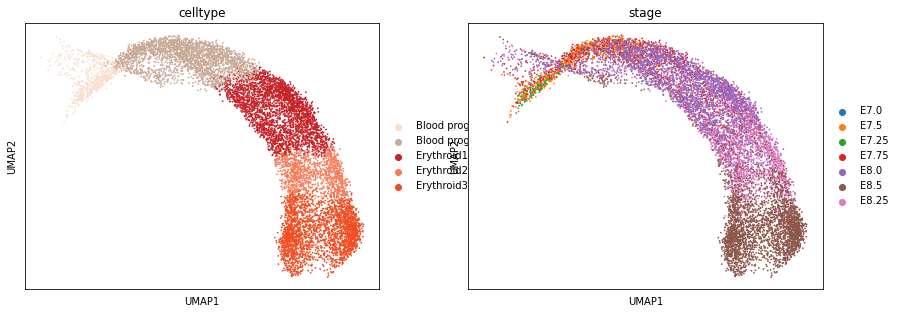

In [8]:
sc.pl.umap(data, color =["celltype","stage"])

In [23]:
marker_genes = ['Smim1', 'Hba-x','Abcg2','Cnn3','Scube2']

# Murk genes

In [14]:
murk_genes = list(pd.read_csv(data_dir+'murk_genes_mouse.txt',sep=" ",header=None)[0])
sc.pp.highly_variable_genes(data,n_top_genes=100,flavor='cell_ranger')
fitted_genes = murk_genes #np.unique(np.append(murk_genes,gene_names[Data.var['highly_variable']]))

In [15]:
idx = [np.where(gene_names==gene)[0] for gene in fitted_genes]
idx = np.concatenate(idx).ravel()
fitted_genes = gene_names[idx]

**Slice the count matrix and get X**

In [17]:
n,p = data[:,idx].X.shape
X = np.zeros((n,p,2))
X[:,:,0]= data.layers["unspliced"].toarray()[:,idx]
X[:,:,1]= data.layers["spliced"].toarray()[:,idx]
X.shape

(9815, 89, 2)

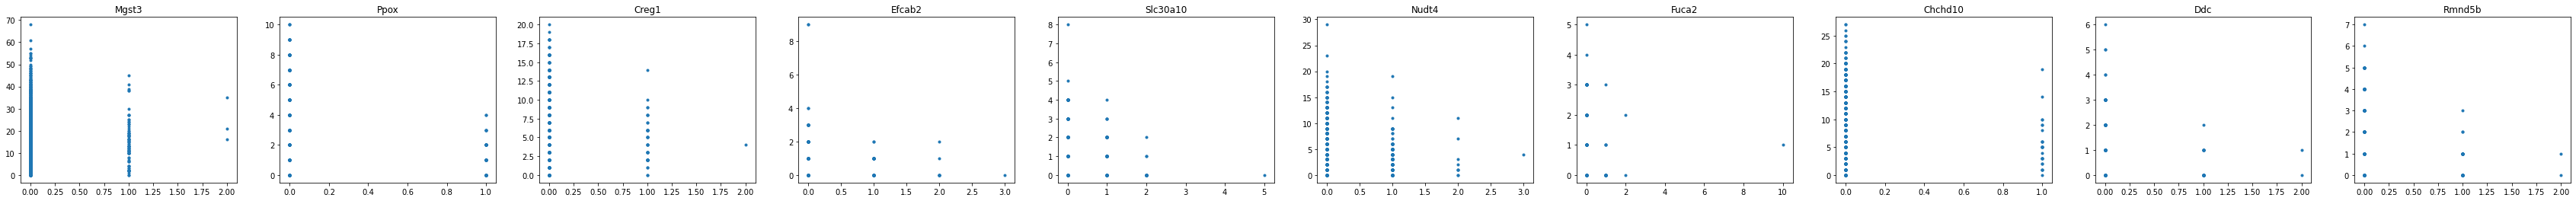

In [18]:
plot_p=10
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for j in range(plot_p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(fitted_genes[j])

In [25]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Hba-x', 'Abcg2'], dtype='object', name='index')


## Fitting without prior

In [21]:
topo = np.array([[0,1]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,parallel=True,n_threads=4,epoch=100)

run method fit_multi_init
trial 1


 25%|██▌       | 25/100 [00:15<00:46,  1.63it/s]

trial 2



 43%|████▎     | 43/100 [00:28<00:37,  1.51it/s]

trial 3



 39%|███▉      | 39/100 [00:22<00:35,  1.71it/s]


In [27]:
topo = np.array([[0]])
tau = (0,1) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,parallel=True,n_threads=4,epoch=100)

run method fit_multi_init
trial 1


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]

trial 2



 58%|█████▊    | 58/100 [00:27<00:19,  2.14it/s]

trial 3



 39%|███▉      | 39/100 [00:18<00:28,  2.11it/s]


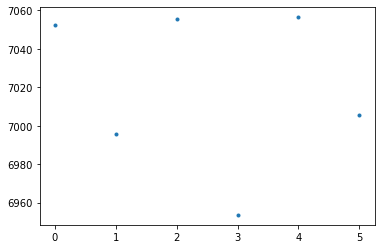

In [33]:
plt.plot(traj.elbos,'.')

In [30]:
traj.compute_AIC(X)

-138517191.20695034

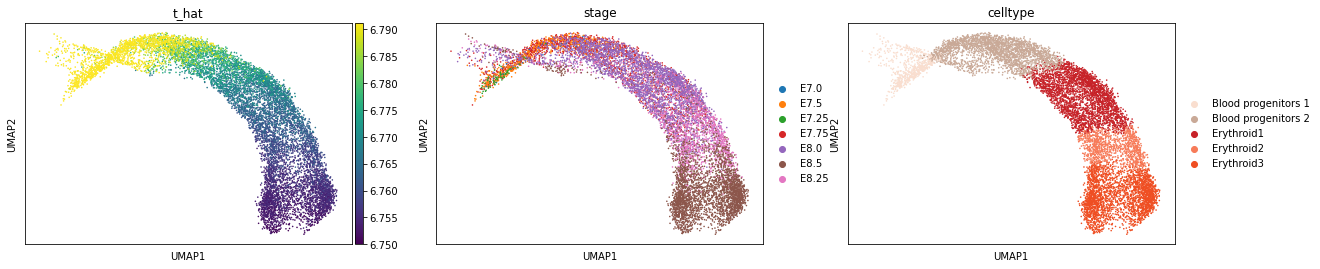

In [28]:
data.obs["t_hat"]=traj.Q[:,0]@traj.t/24+6.75
sc.pl.umap(data,color=["t_hat","stage","celltype"],size=10)

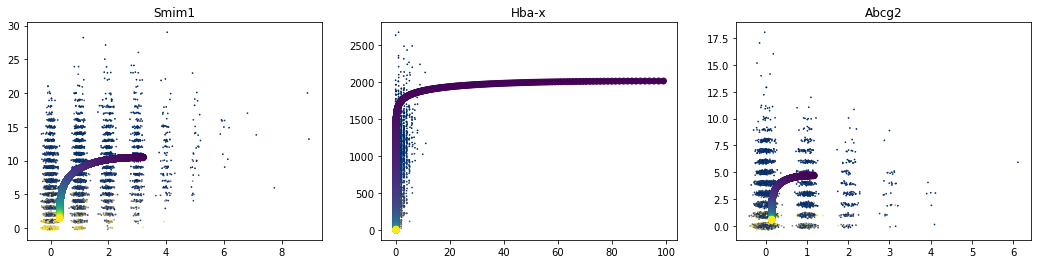

In [31]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

## Fitting with prior

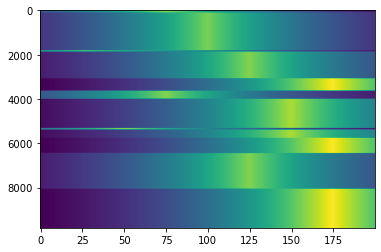

In [189]:
n, p, _ = X.shape
m = 200
t = np.linspace(6.75,8.75,m)
mu = (7,7.25,7.5,7.75,8,8.25,8.5) 
b = 1

Q0 = np.zeros((n,1,m))
for i,stage in enumerate(stages):
    cell_idx = np.where(Data.obs['stage'] == stage)
    Q0[cell_idx,0] = np.exp(-np.abs(t-mu[i])/b)/2/b
Q0 = Q0/np.sum(Q0,axis=(1,2),keepdims=True)
plt.imshow(Q0[:,0],aspect='auto');

### Laplace prior

In [190]:
topo = np.array([[0,1]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
res = traj.fit(X,prior=Q0,parallel=True,n_threads=4,epoch=100)

run method fit_warm_start


 40%|████      | 40/100 [00:30<00:45,  1.30it/s]


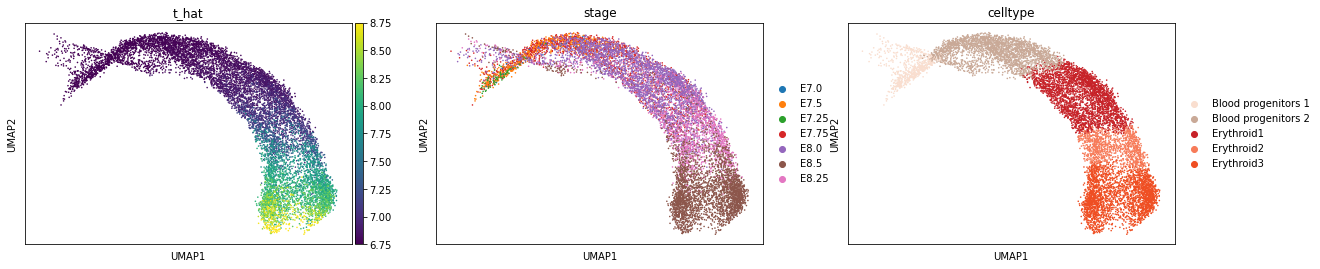

In [191]:
Q,elbos=res
Data.obs["t_hat"]=Q[:,0]@traj.t/24+6.75
sc.pl.umap(Data,color=["t_hat","stage","celltype"],size=10)

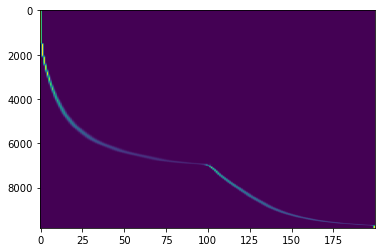

In [192]:
plot_t(traj.Q)

In [193]:
plot_genes = ['Smim1', 'Hba-x','Abcg2','Cnn3','Scube2']
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Hba-x', 'Abcg2'], dtype='object', name='index')


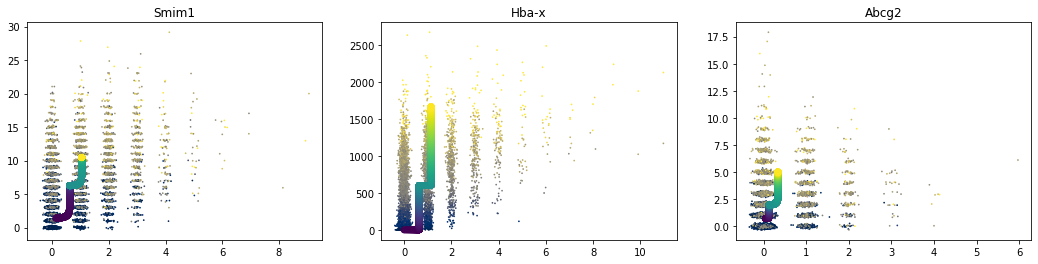

In [194]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

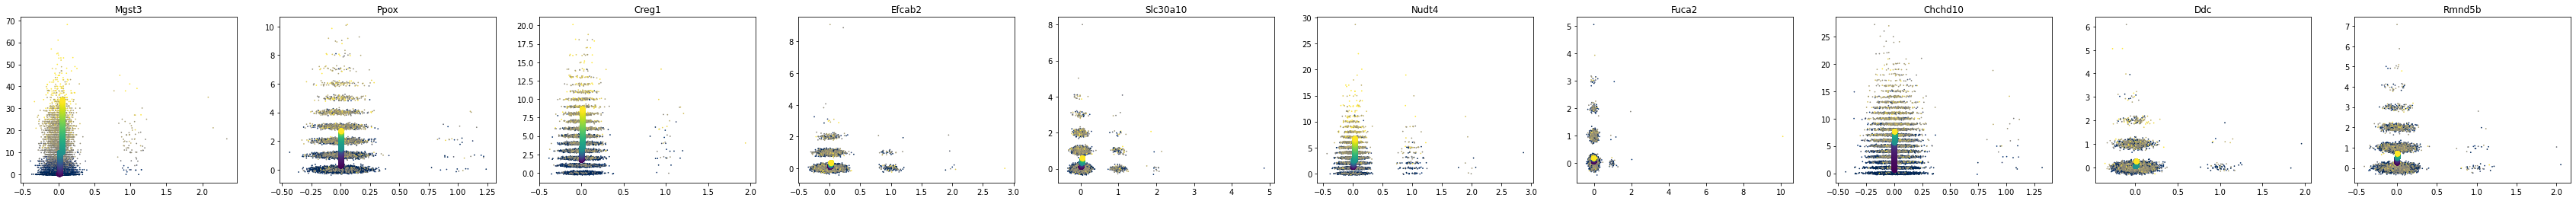

In [195]:
plot_phase(traj,idx=np.arange(10),gene_name=fitted_genes)

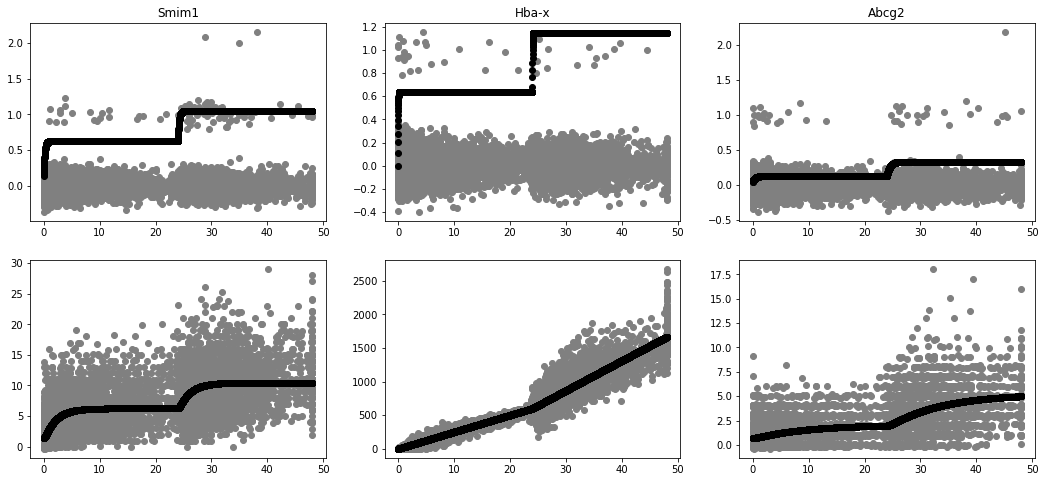

In [196]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

Because the unspliced counts are so low, the ratio of beta/gamma has to be very large. In such scenario, there is time scale seperation and phase plot looks like a (part of) rectangle.

In [202]:
from scipy.spatial import distance

S = data.X.toarray()
dist = distance.cdist(S, S, 'minkowski', p=1.)

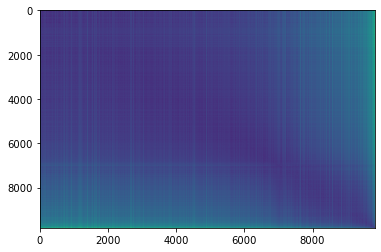

In [205]:
order = np.argsort(data.obs["t_hat"])
sorted_dist = dist[order,:][:,order]
plt.imshow(sorted_dist,aspect="auto");

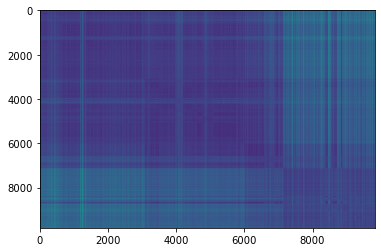

In [206]:
order = np.argsort(data.obs["celltype"])
sorted_dist = dist[order,:][:,order]
plt.imshow(sorted_dist,aspect="auto");

# Selected genes

In [9]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

In [13]:
U = data.layers["unspliced"].toarray()
S = data.layers["spliced"].toarray()
gene_list = select_genes(U,S,data.var_names,mean_min=0.1,var_min=0.5)
len(gene_list)

17

In [26]:
idx = (data.var_names.isin(gene_list)) | (data.var_names.isin(marker_genes))
fitted_genes = data.var_names[idx]
u=data.layers["unspliced"][:,idx].toarray()
s=data.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [30]:
plot_mask = fitted_genes.isin(marker_genes)
print(fitted_genes[plot_mask])
plot_idx = np.arange(len(fitted_genes))[plot_mask]

Index(['Cnn3', 'Smim1', 'Abcg2', 'Scube2', 'Hba-x'], dtype='object', name='index')


In [31]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X, n_init=3, parallel=True, n_threads=4)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]

trial 2



100%|██████████| 20/20 [00:05<00:00,  3.37it/s]

trial 3



100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


In [32]:
traj.compute_AIC(X)

-102651037.06089555

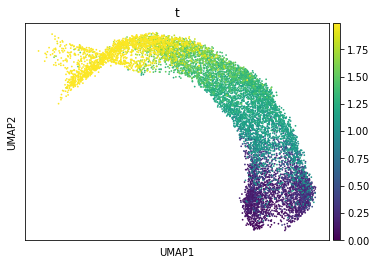

In [33]:
data.obs['t'] = traj.Q[:,0]@traj.t
sc.pl.umap(data,color=['t'])

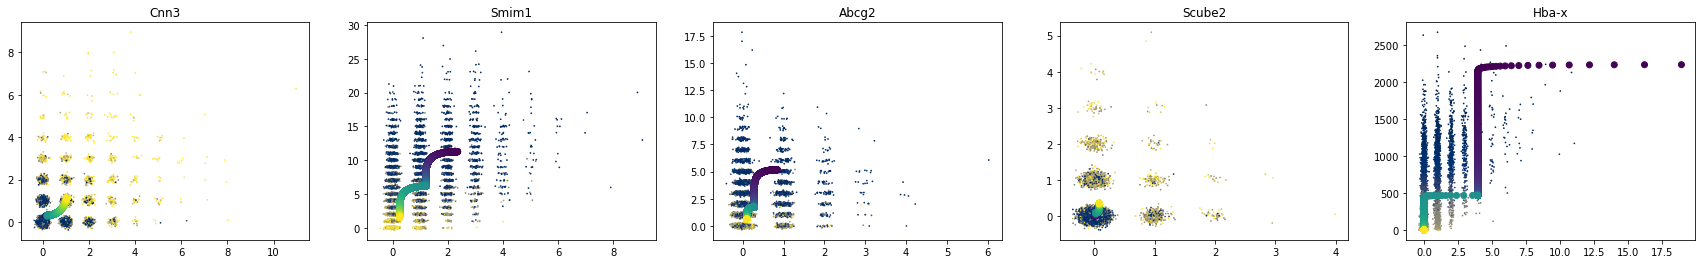

In [34]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)